In [3]:
## general imports
import pandas as pd
import numpy as np
import os, sys, gc, warnings
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno
warnings.simplefilter("ignore")


## Overview

The data set is separated in to two tables. Train_transaction contains information about transaction and train_identity contains information about customers.The objective of this project is to predict if an online transaction in the dataset is fraudulent or not. Most of the data is heavily anonimized but there are some hints given by the data provider. The target variable is 'isFraud'. Noting that only apporoximately 25% of the transaction dataset has associated identity data, this part of the analysis is only base on the transaction dataset.  I would like to see if using the identity dataset adds any value to model predictions in a later stage.  Based on that information, in the transaction dataset

Numerical features 

    C1-C15 (discreet):  counts of phone numbers, emails, names, device, IP address, billing address, etc for both purchaser and recipient.
    D1-D15 (discreet) : timedelta vaues (D1= time since the first transaction , time since email address was used, time since last transaction etc)
    V features (V1-V339) (discreet) : anonymous  engineered features as well as row features
    TransactionDT: timedelta corresponding to date of purchase
    TransactionAmt : purchase amount in USD

Categorical features

    ProductCD : 
    P_emaildomain: purchaser email domain
    R_emaildomain : recipient email domain
    M1-M9 : attribute of matching check. eg. is phone area code matching billing zipcode? purchaser and recipient first and last names match? etc
    card 4: specific card type ( american express, mastercard etc) 
    card 6 : debit or credit
    card 1,2,3,5 : categorical features but numerical values 
    add1, add2: numerical values corresponding to purchaser billing region, billing country
    

The aim of the EDA is to answer the following questions and preprocess the data to use in a model. 

    What type of data we have?
    How many unique and  missing values do we have?
    Whats the target distribution like?
    Is there a difference in features between fraud and non-fraud transactions?
    What features show  interesting patterns?
    What does the correlation analysis tell us about the features? 

In [ ]:
## read data
identity = pd.read_csv ("C:/Users/hawia/Documents/Capstone/data/train_identity.csv" )
transaction = pd.read_csv ( "C:/Users/hawia/Documents/Capstone/data/train_transaction.csv" )
## shape of data
print (f'Transaction dataset has {transaction.shape[0]} rows and {transaction.shape[1]} columns')
print (f'Identity dataset has {identity.shape[0]} rows and {identity.shape[1]} columns')

In [ ]:
transaction.describe()

In [ ]:
identity.head()

In [ ]:
# merge the transaction and identity tables (left join)

df = pd.merge (transaction, identity, on = "TransactionID", how = "left")
print (f'There are {df.shape[0]} rows and {df.shape[1]} columns in the df')

In [ ]:
# check how much of the transaction data has associated identitiy information

count_match = np.sum (transaction.index.isin (identity.index.unique()))
match_percentage= np.round(100 * count_match / len (df))
print (f'There are {count_match}, {match_percentage} % transactions with associated identity data')
del transaction, identity
gc.collect()

In [ ]:
# memmory reduction function borrowed from ...https://www.kaggle.com/kyakovlev/ieee-data-minification
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [ ]:
# only 25% percent of the transaction data has a corresponding identity data and therefore identity dataset was not used 
# dataframe with only transaction data
df_tran = reduce_mem_usage(transaction)
df_tran.to_pickle ('pickled.pkl')


In [29]:
# transaction only dataframe 
df_trans = pd.read_pickle ('pickled.pkl')
 

In [20]:
df_trans.describe(include= 'all')

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540,590540.000000,581607.0,588975.0,588963,586281.0,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.0,82351.0,82351.0,82351.000000,82351.000000,82351.000000
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,439670,NaN,NaN,NaN,384767,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.282270e+06,0.034990,7.372311e+06,NaN,NaN,9898.734658,NaN,NaN,NaN,NaN,...,0.775391,721.741455,1375.778564,1014.619934,NaN,NaN,NaN,55.352417,151.160538,100.700874
std,1.704744e+05,0.183755,4.617224e+06,NaN,NaN,4901.170153,NaN,0.0,NaN,0.0,...,0.000000,6217.229980,11169.515625,7955.782227,NaN,NaN,NaN,668.375854,1095.057739,814.953247
min,2.987000e+06,0.000000,8.640000e+04,0.250977,NaN,1000.000000,100.0,100.0,NaN,100.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,NaN,6019.000000,214.0,150.0,NaN,166.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,NaN,9678.000000,361.0,150.0,NaN,226.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,NaN,14184.000000,512.0,150.0,NaN,226.0,...,0.000000,0.000000,25.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


## Define some plotting and summary functions

In [21]:
# function to plot numeric features (feature vs time (TransactionDT))
def numeric(col):
    #df_trans.set_index('TransactionDT')[col].plot(style='.', title = col +"values over time", figsize =(15,3))
    df_final[df_final['isFraud'] == 0].set_index('TransactionDT')[col].plot(style='.',title = col + ' values over time (blue=no-fraud, orange=fraud)' , figsize=(15, 3))
    df_final[df_final['isFraud'] == 1].set_index('TransactionDT')[col].plot(style='.',title =col + ' values over time (blue=no-fraud, orange=fraud)' , figsize=(15, 3))
    plt.show
      
    
# summary statistics 
def summ_stats(df): 
    perc_missing = np.round((df.isna().sum()/len(df))*100, 4)
    unique = df.nunique (dropna = False)
    stats = pd.DataFrame (index = None, data = {'unique' : unique,  'perc_missing' : perc_missing, 'col_name' : df.columns, 'type' : df.dtypes})\
               .reset_index().drop('index',axis=1)
    
    return stats

# function to plot categorical features with reasonable number of categories (non-numeric)
def categorical(df, col, lim=2000):
    #df_trans[col] = df[col].fillna("Missing")
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    g= sns.countplot(x= col, data = df, hue ="isFraud")
    g.set_title(f"{col}", fontsize=18)
    g.set_xlabel("Category", fontsize=16)
    g.set_ylabel("Count", fontsize=16)
    plt.show()
    
# function to plot correlation 
def correlated (col):
    plt.figure(figsize=(15,15))
    sns.heatmap(df_trans[col].corr(), cmap='RdBu_r', annot=True, center=0.0)
    plt.show()

## Data preprocessing

For this initial stage, the data preprocessing steps are
    
    Drop all features that have 60% or more missing values
    Check for correlations between the remaining features
    Drop features that are highly correlated (r=0.8 or more)
    Use remaining features to build an initial model.
    

# Search for similarity between features based on their NaN structure
We see that a lot of features share a similar Nan structure which may show a relationship between them. 

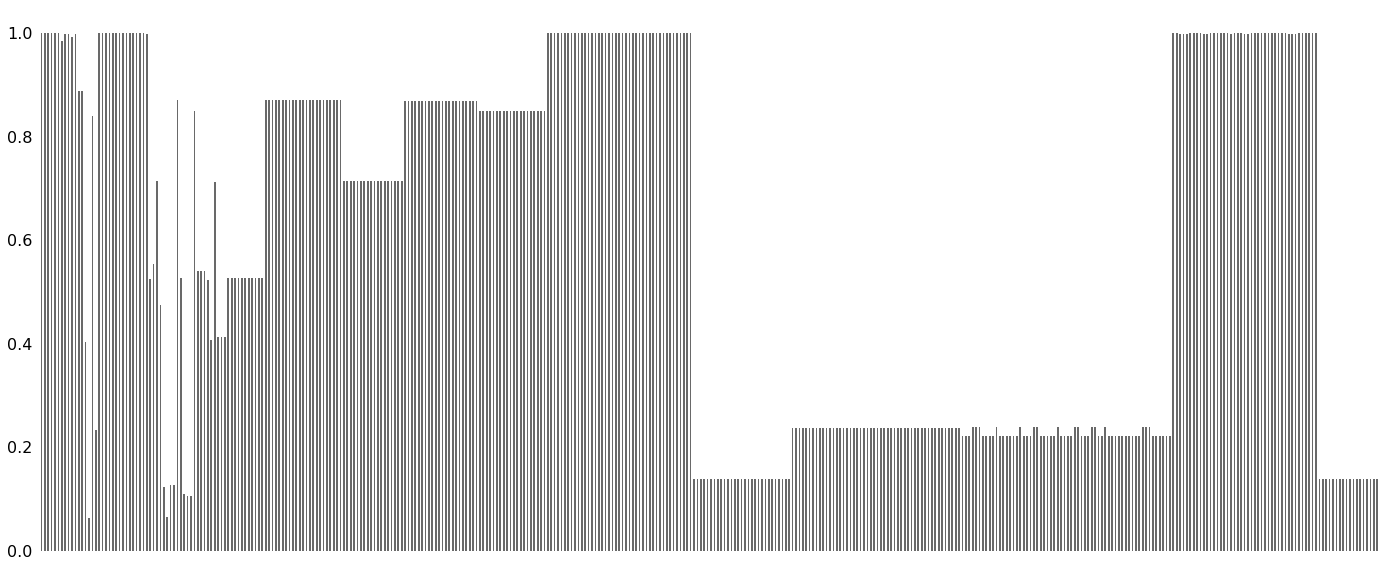

In [22]:
## check for any similarity in nan structure
msno.bar(df_trans)

There are also a lot of features with more than 60% missing data. 

In [23]:
# columns grouped by the percentage of missing data
pd.options.display.max_colwidth =500
col_na_group= summ_stats(df_trans).groupby('perc_missing')['col_name']\
                                    .unique().reset_index()\
                                    .sort_values('perc_missing', ascending = False)
col_na_group

,perc_missing,col_name
43,93.6284,[dist2]
42,93.4099,[D7]
41,89.5093,[D13]
40,89.4695,[D14]
39,89.0410,[D12]
38,87.6068,[D6]
37,87.3123,"[D8, D9]"
36,86.1237,"[V138, V139, V140, V141, V142, V146, V147, V148, V149, V153, V154, V155, V156, V157, V158, V161, V162, V163]"
35,86.1227,"[V143, V144, V145, V150, V151, V152, V159, V160, V164, V165, V166]"
34,86.0550,"[V322, V323, V324, V325, V326, V327, V328, V329, V330, V331, V332, V333, V334, V335, V336, V337, V338, V339]"


In [24]:
# drop any column that has more than 60% or more missing datapoints
threshold =0.40* len(df_trans)
df_complete = df_trans.dropna(axis=1, thresh=threshold)
# save the final dataset 
df_complete.to_pickle ('complete.pkl')
df_final= pd.read_pickle('complete.pkl')
df_final.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_final.describe(include = 'all')

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540,590540.000000,581607.0,588975.0,588963,586281.0,...,590528.0,589271.0,589271.0,589271.0,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,439670,NaN,NaN,NaN,384767,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.282270e+06,0.034990,7.372311e+06,NaN,NaN,9898.734658,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,109.817917,247.600327,162.151230,18.372953,42.073849,28.327173
std,1.704744e+05,0.183755,4.617224e+06,NaN,NaN,4901.170153,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,2269.960449,3979.808105,2792.950928,331.837372,473.217529,381.328247
min,2.987000e+06,0.000000,8.640000e+04,0.250977,NaN,1000.000000,100.0,100.0,NaN,100.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,NaN,6019.000000,214.0,150.0,NaN,166.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,NaN,9678.000000,361.0,150.0,NaN,226.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,NaN,14184.000000,512.0,150.0,NaN,226.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Check for target distribution

We notice the data is imbalanced with fraud consisting only 3.5% of the data. 


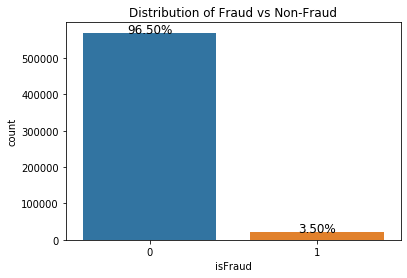

In [12]:
total = len(df_final)
g= sns.countplot(x= 'isFraud', data = df_final)
g.set_title('Distribution of Fraud vs Non-Fraud')
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.show()

## checking for TransactionAmt
We notice the transaction amount between fraud and non-fraudulent transactions is similar. There is an outlier in the transaction amount data and it has been removed from the datset. 

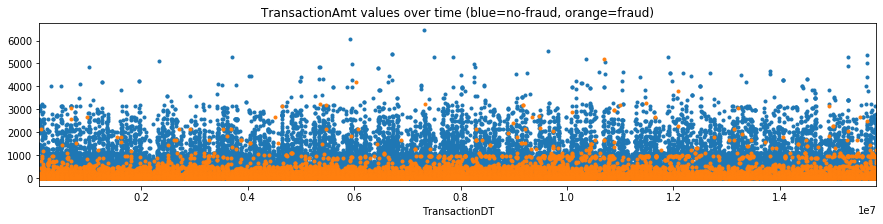

In [13]:
for col in ['TransactionAmt']:
    numeric (col)

## Checking for C features

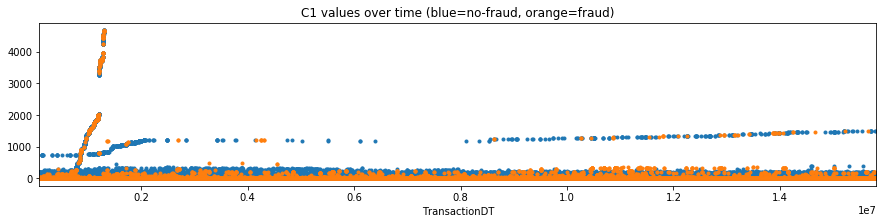

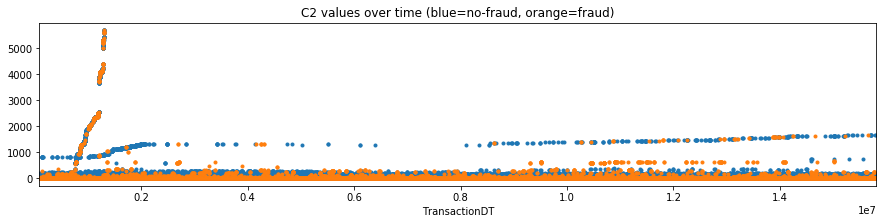

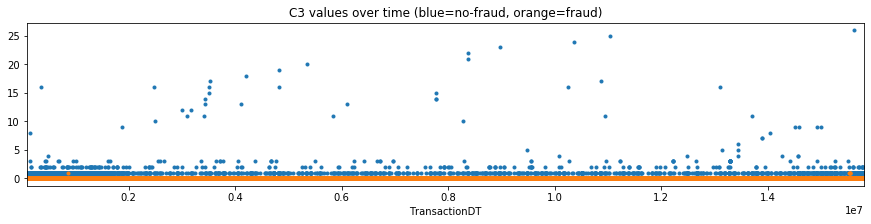

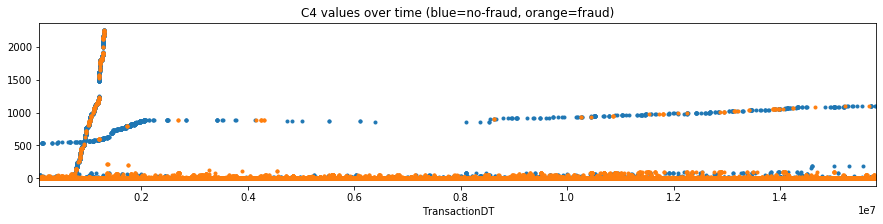

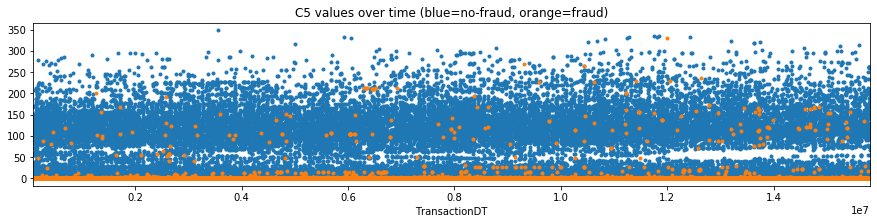

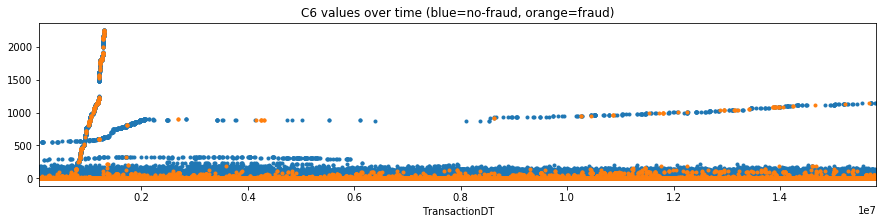

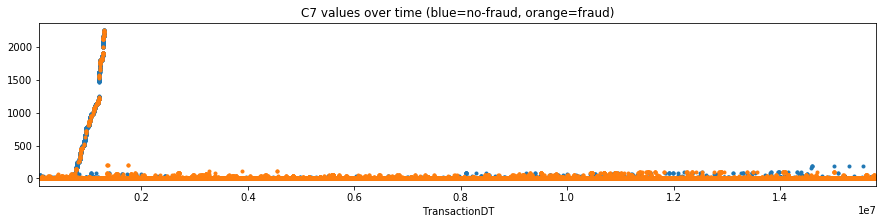

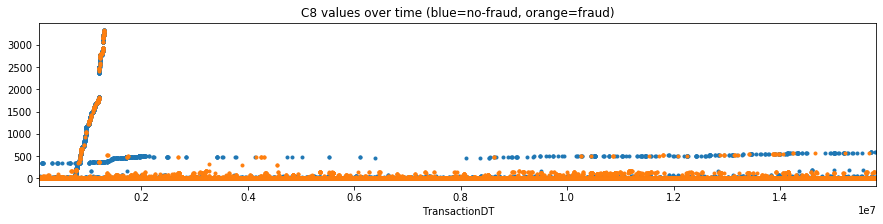

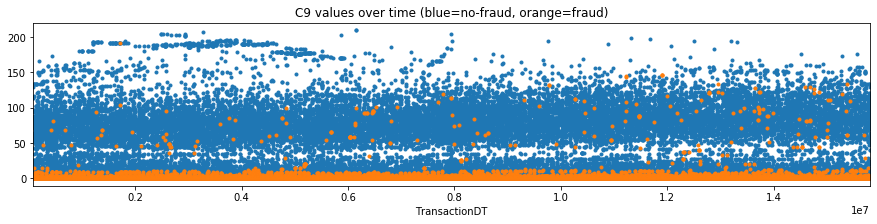

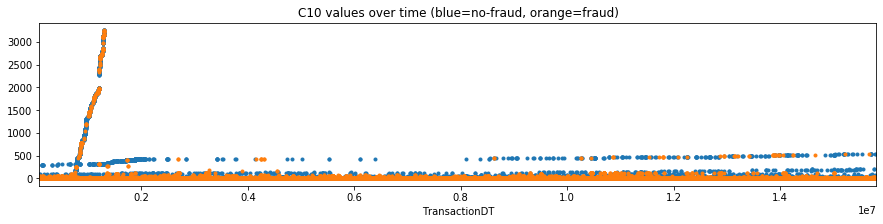

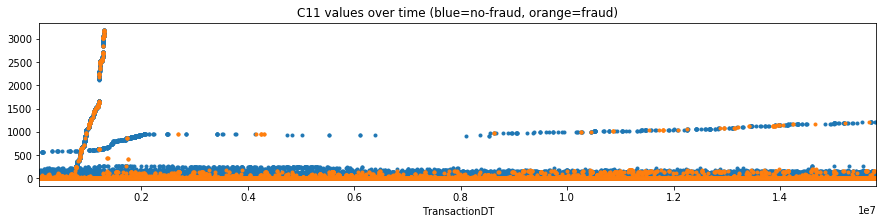

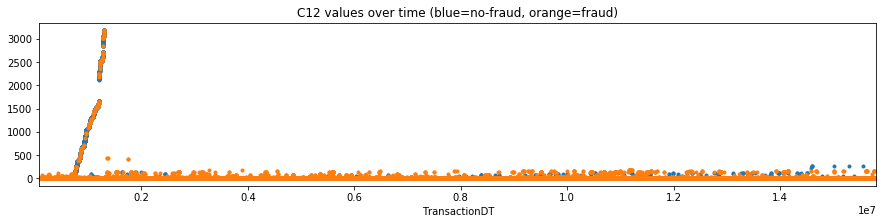

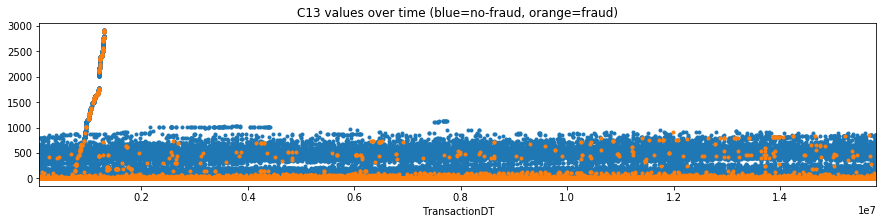

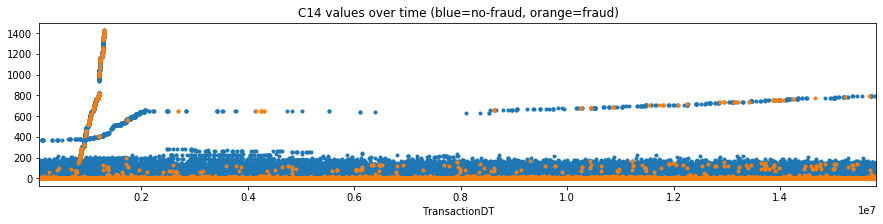

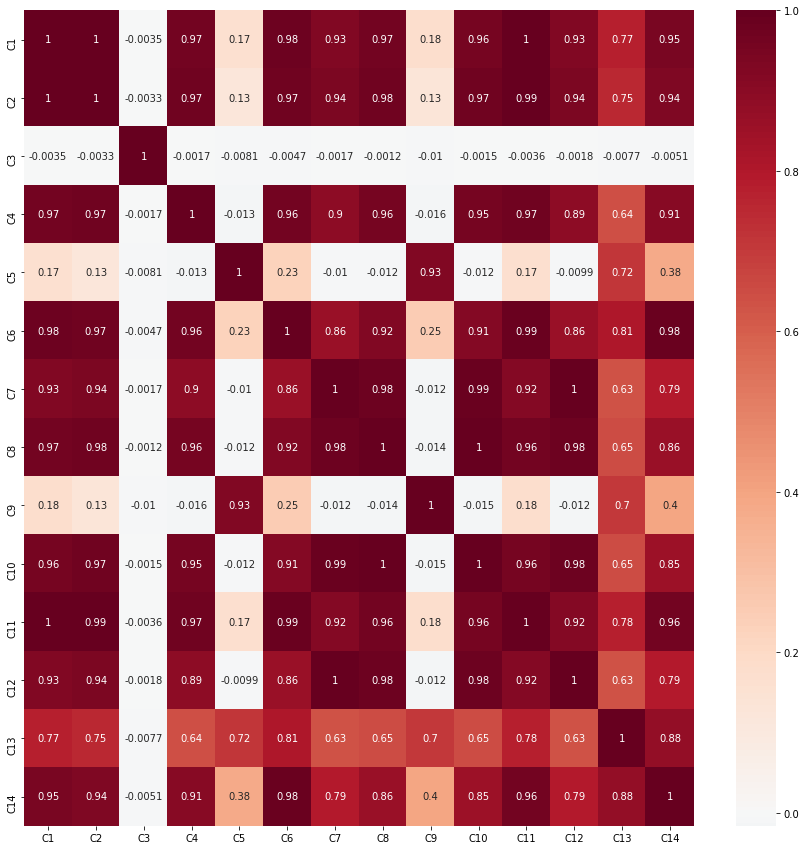

In [14]:
Cs = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
for col in Cs:
    numeric(col)
    plt.show()
correlated (Cs)

## Checking for V features

In [ ]:
# checking V features 
Vs = [col for col in df_trans if col.startswith('V')]

for col in Vs:
    numeric(col)
    plt.show()
    
    


## Checking for D features

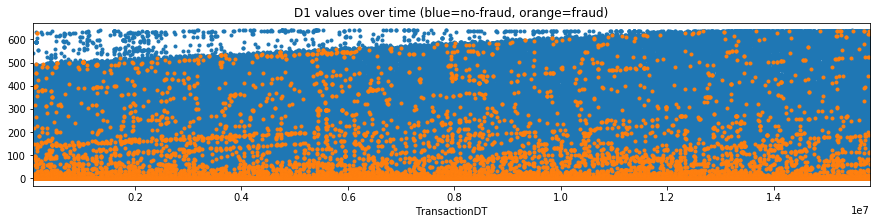

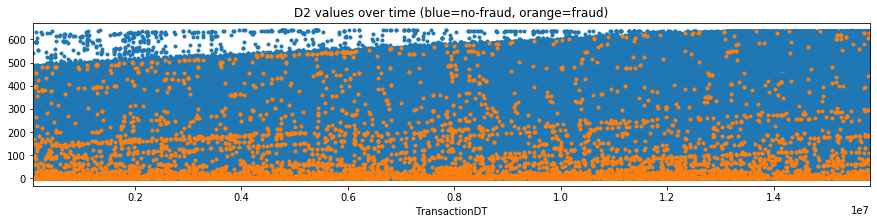

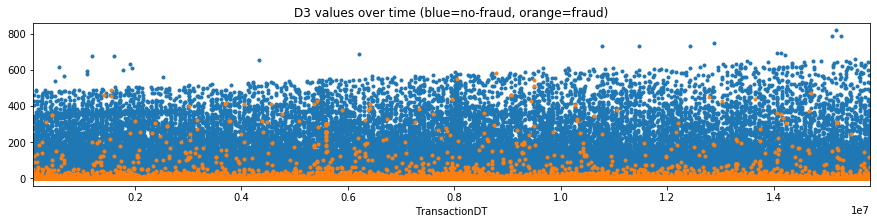

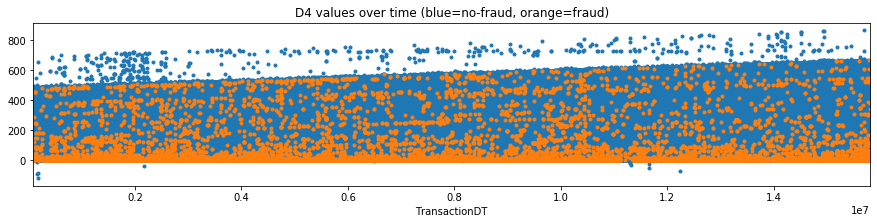

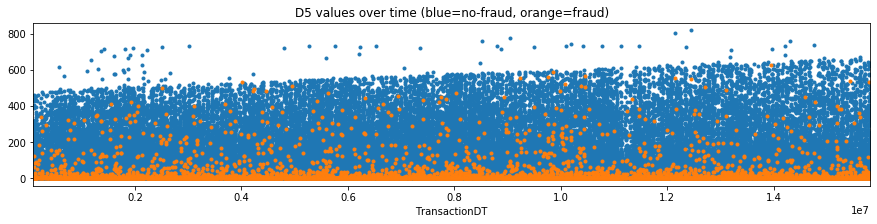

KeyError: 'D6'

In [15]:
# checking D features
Ds = [col for col in df_trans if col.startswith('D')]

for col in Ds:
    numeric(col)
    plt.show()
correlated(Ds)


## Checking for the distribution of TransactionAmt by target

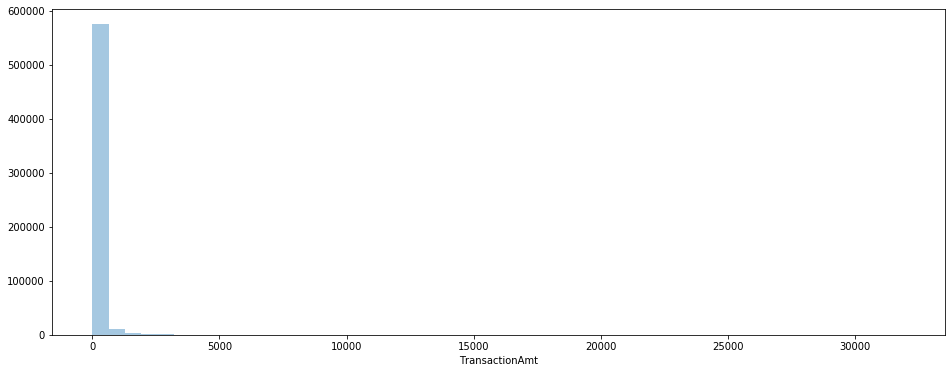

In [27]:
# distribution of TransactionAmt by target
# notice the outlier...and get rid of it 
#df_trans = df_trans[df_trans.TransactionAmt <= 30000]

plt.figure(figsize=(16, 6))
#sns.boxplot(x="isFraud", y="TransactionAmt", data=df_trans)
sns.distplot(df_trans.TransactionAmt, kde = False)
plt.show()
# notice the outlier...and get rid of it 
#dd = df_trans[df_trans.TransactionAmt >= 'Tina']



(0, 10000)

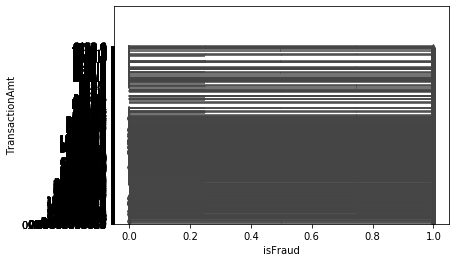

In [28]:
d_trans= df_trans[df_trans.TransactionAmt < 31000]
sns.boxplot(x= 'isFraud', y= 'TransactionAmt', data = d_trans, orient = 'h')
plt.ylim(0, 10000)



## Checking for M features

In [ ]:
Ms = [col for col in df_final if col.startswith('M')]
cards= ['card4', 'card6', 'ProductCD']
categ= Ms+cards

for col in categ :
    #df_final[col] = df_final[col].cat.add_categories('Missing').fillna("Missing")
    categorical(df_final, col)


## Checking for Card features

## Looking at categorical features with too many unique values

In [ ]:
# categorical features with too many unique values to plot...looking at the top 15 values

vars =['P_emaildomain', 'R_emaildomain', 'addr1', 'addr2','card1','card2', 'card3', 'card5']
for col in vars:
    plt.figure(figsize=(15,5))
    sns.countplot(x=df_trans[col], data=df_trans, order=df_trans[col].value_counts().iloc[:15].index, hue = 'isFraud')
    plt.xticks(rotation=30)
    plt.show()
